<a href="https://colab.research.google.com/github/AV-Gorshkov/Python_netology/blob/main/PY_%D0%AD%D0%BB%D0%B5%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%80%D0%BD%D1%8B%D0%B5_%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D1%8B_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0_%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D1%85_%D1%80%D1%8F%D0%B4%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Задание**

- Возять ряд — стационарный и не стационарный. Приблизьте оба варианта моделями из класса MA.
- Оцените качество модели

In [63]:
import pandas as pd
import numpy as np

# from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
# from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
# from scipy.stats import boxcox
%matplotlib inline

from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [64]:
# # изменим размер графиков
# from pylab import rcParams
# rcParams['figure.figsize'] = 15, 7

In [65]:
#  загрузка данных
param = r'/content/drive/My Drive/Нетология/ML/Временные_ряды/1_знакомство_с_временными_рядами/Series/'

file_1 = 'daily-total-female-births-in-cal.csv'
file_2 = 'monthly-sales-of-company-x-jan-6.csv'

female_births = pd.read_csv(f'{param}{file_1}', sep = ',')
sales_of_company_x = pd.read_csv(f'{param}{file_2}', sep = ',')

In [66]:
# функция автокорреляции
def fun_series (y, indx=1):

  total = pd.DataFrame( columns=['Lag','R'])

  for i in range(1, indx + 1):

    ser_a = pd.Series( y[:-i], name='A').reset_index(drop=True)
    ser_b =  pd.Series( y[i:], name='B').reset_index(drop=True)

    df = pd.concat([ser_a, ser_b], axis=1)

    total = pd.concat([total, pd.DataFrame( [ {'Lag': i, 'R': df.corr().at['A','B']} ] ) ])
  return total.sort_values(by='R', ascending=False).reset_index(drop=True)


# функция  train/test/val для ряда
def split_train_test_val(ser, train, val):
  _train = int(len(ser) * train)
  _val = int(len(ser) * val)
  _test = len(ser) - _train - _val
  return ser[:_train], ser[_train : _train + _test], ser[-_val:]

#1. Стационарный ряд.
Датасет "Daily total female births in California"

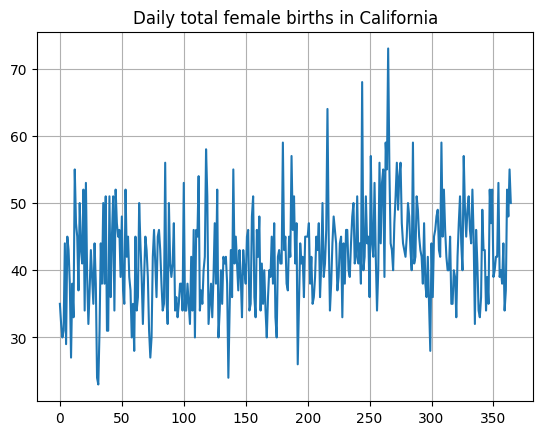

In [67]:
# Визуализация графика

name ='Daily total female births in California'

stac = female_births['Count']

plt.plot(stac)
plt.title(name)
plt.grid()
plt.show()

Ряд стационарный - нет сезонности и тренда, использовать методы DEMA и TEMA не логично. Построить прогноз с помощью методов MA, WMA, EMA - не получится, за пределами окна график покажет среднее значение

In [68]:
# Метод EMA
def ema (series, alpha, n_pred=None):
    result = [series[0]]

    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)

    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]

        result.append(res)
        predictions.append(res)

    return series._append(pd.Series(predictions[1:]), ignore_index=True) #, pd.Series(result)


#  визуализация графика (EMA и предсказания)

def ema_plt (ser, alpha, predict_n, ser_plt = None, title_plt = None):
  if ser_plt is None:
     ser_plt = ser
  title = f'alpha = {alpha}'

  if title_plt is not None:
    title = title + " " + title_plt

  s = ema(ser, alpha, predict_n)

  with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot( ser_plt, color='blue',label='original')
    plt.plot( s[:len(ser)], color='orange', label='EMA', linestyle='dashed')
    plt.plot( [j + len(ser) for j in range (-1, predict_n)], s[len(ser) - 1:], color = 'green', label = 'EMA_predict' )
    plt.title(title)
    plt.legend()
    plt.show()

# MSE - определение ошибки ф-ции EMA
def ema_mse (alpha, *param):
    alpha =  alpha
    train = param[0]
    test = param [1]
    result = ema(train, alpha, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)

    return error

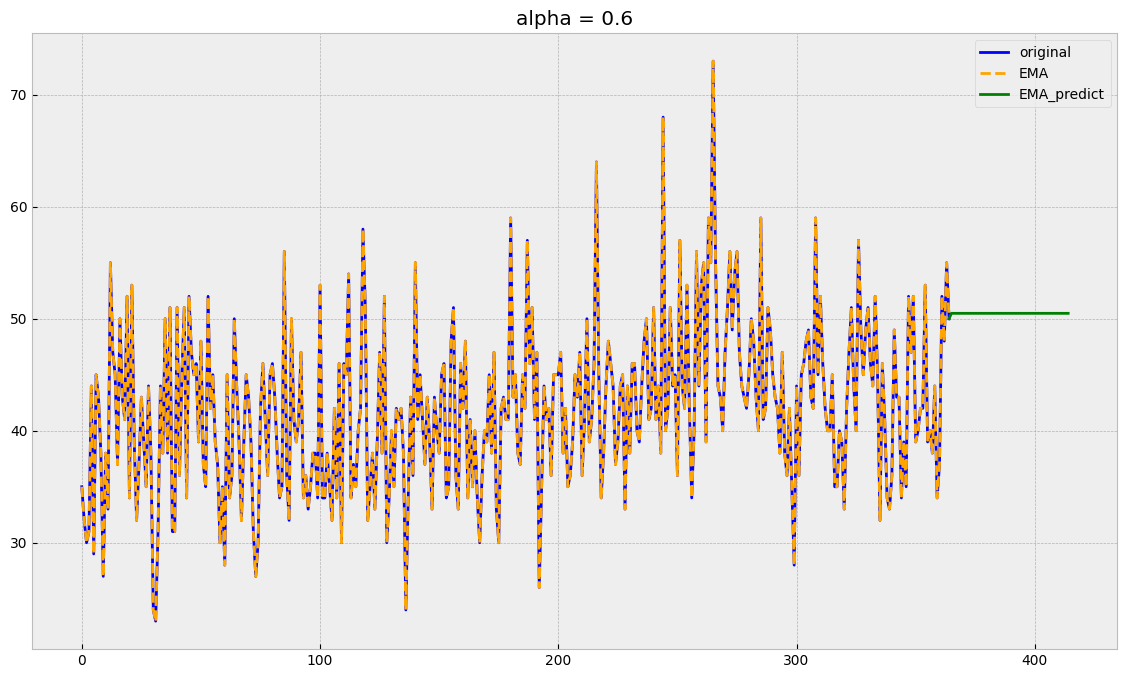

In [69]:
# построим прогноз на 50 дней, для случаного значения alpha
predict_n = 50
alpha = 0.6

ema_plt(stac, alpha, predict_n)

In [70]:
#  разделим выборку на train и test

train, test, val = split_train_test_val(stac, 0.6, 0.2)

# ф-ция оптимизации

opt = minimize( ema_mse, 0, args=(train, test), bounds=((0, 1),) )
alpha_opt = opt.x[0]
print('alpha = ', alpha_opt)

alpha =  0.18078174274042452


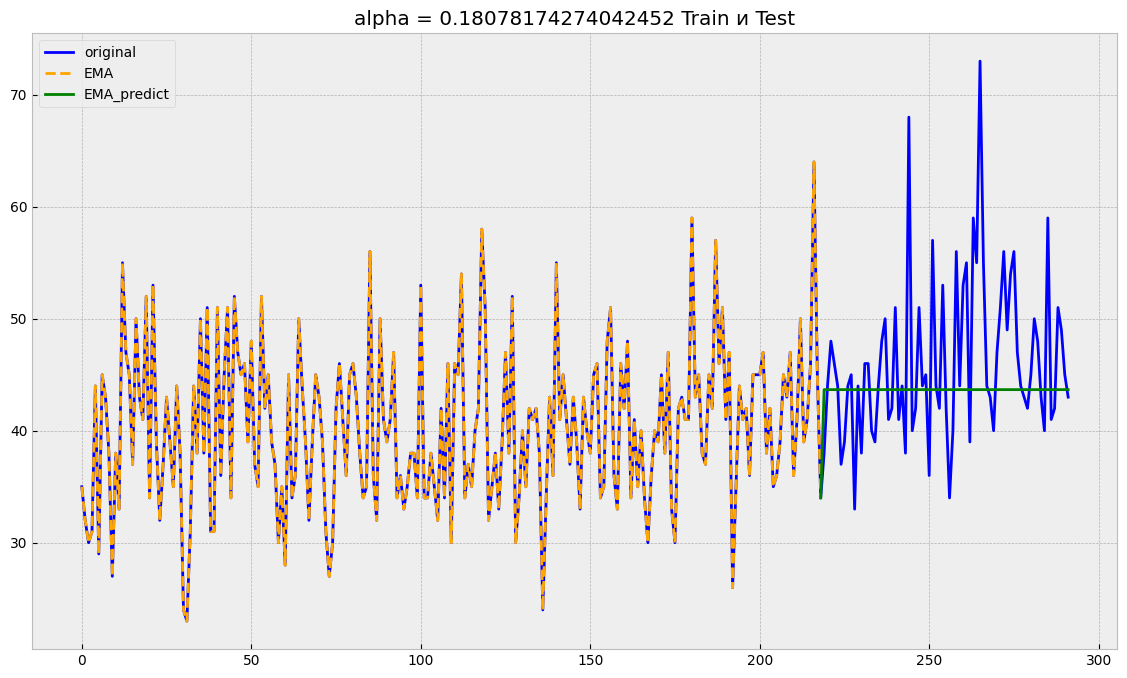

MSE =  58.309941176456185


In [71]:
#  построим график для нового значения alpha и определим ошибку

ema_plt (train, alpha_opt, predict_n = len(test), ser_plt = train._append(test), title_plt = "Train и Test")

print('MSE = ', ema_mse(alpha_opt, train, test))

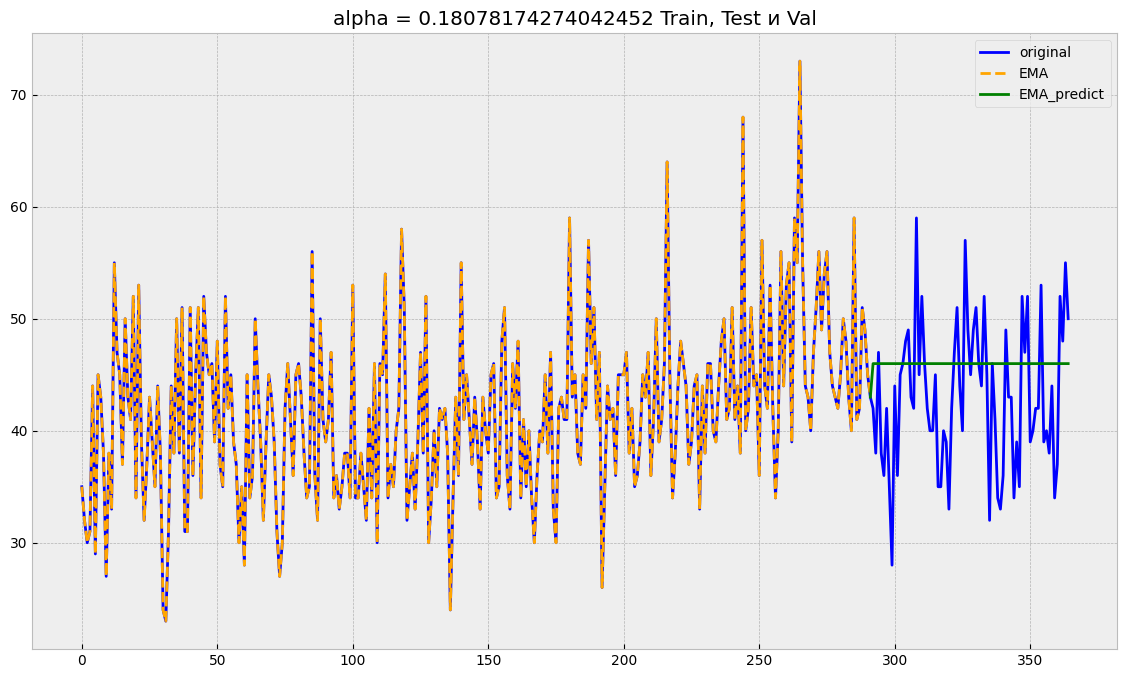

MSE =  50.055069403709346


In [72]:
#  построим график на Val выборке и определим ошибку

ema_plt (train._append(test), alpha_opt, predict_n = len(val), ser_plt = stac, title_plt = "Train, Test и Val")

print('MSE = ', ema_mse(alpha_opt, train._append(test), val) )

In [73]:
# метод MA

def ma (ser,  n_len, predict_n):
  ser_new = ser.rolling( n_len ).mean()

  for _ in range(predict_n):
    ser_new = ser_new._append(pd.Series( [ ser_new[ - n_len: ].mean() ]), ignore_index=True )
  print( 1 )
  return ser_new

# Метод WMA
def wma (ser, w, predict_n):
  n_len = len(w)

  if not isinstance (w, np.ndarray):
    w = np.array(w)
  if not isinstance (ser, pd.Series):
    ser = pd.Series(ser)

  new_ser = ser.rolling(n_len).apply( lambda j: (j * w).sum() / w.sum(), raw=True)
  for n in range(predict_n):
    new_ser = new_ser._append(pd.Series (np.dot (new_ser [ - n_len:], w) / w.sum() ), ignore_index=True)

  return new_ser

#  визуализация графика (MA и предсказания)
def ma_plt (ser, lag, predict_n, ser_plt=None, title_plt=None):
  if ser_plt is None:
     ser_plt = ser
  title = ''

  if title_plt is not None:
    title = title + " " + title_plt

  s = ma(ser, lag, predict_n)

  with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot( ser_plt, color='blue',label='original')
    plt.plot( s[:len(ser)], color='orange', label='MA', linestyle='dashed')
    plt.plot( [j + len(ser) for j in range (-1, predict_n)], s[len(ser) - 1:], color = 'green', label = 'MA_predict' )
    plt.title(title)
    plt.legend()
    plt.show()


#  визуализация графика (WMA и предсказания)

def wma_plt (ser, w, predict_n, ser_plt=None, title_plt=None):
  if ser_plt is None:
     ser_plt = ser
  title = ''

  if title_plt is not None:
    title = title + " " + title_plt

  s = wma(ser, w, predict_n)

  with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot( ser_plt, color='blue',label='original')
    plt.plot( s[:len(ser)], color='orange', label='WMA', linestyle='dashed')
    plt.plot( [j + len(ser) for j in range (-1, predict_n)], s[len(ser) - 1:], color = 'green', label = 'WMA_predict' )
    plt.title(title)
    plt.legend()
    plt.show()

# MA - определение ошибки ф-ции
def ma_mse (*param):
    train = param[0]
    test = param [1]
    lag =  param[2]
    result = ma(train, lag, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)

    return error

# WMA - определение ошибки ф-ции WMA
def wma_mse (*param):
    train = param[0]
    test = param [1]
    w =  param[2]
    result = wma(train, w, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)

    return error

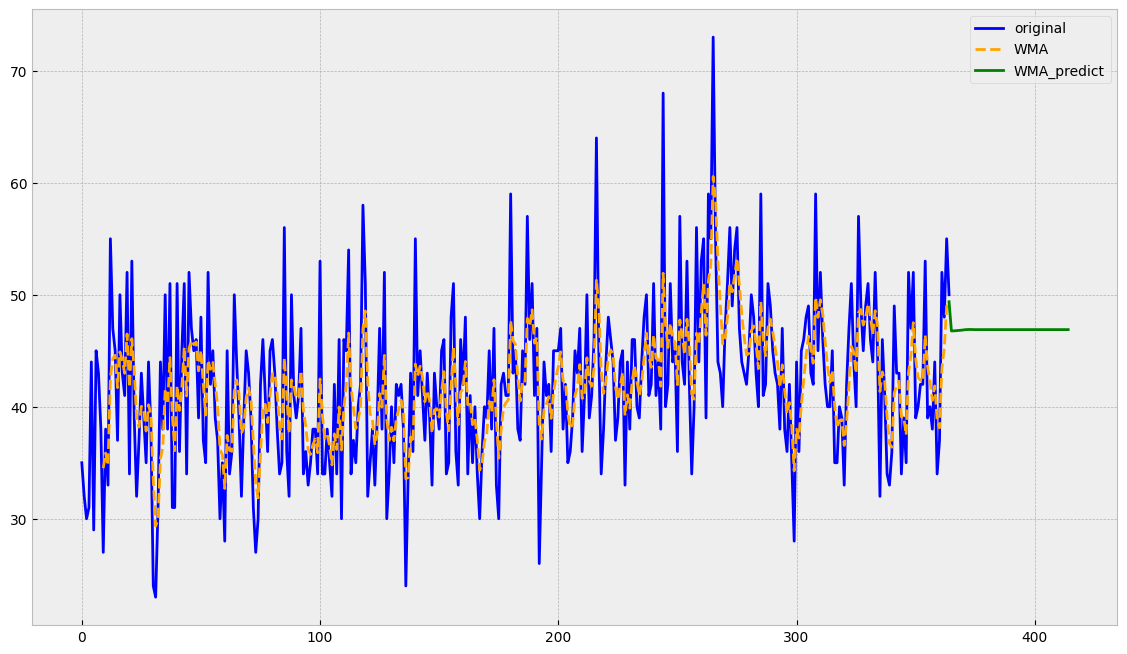

1


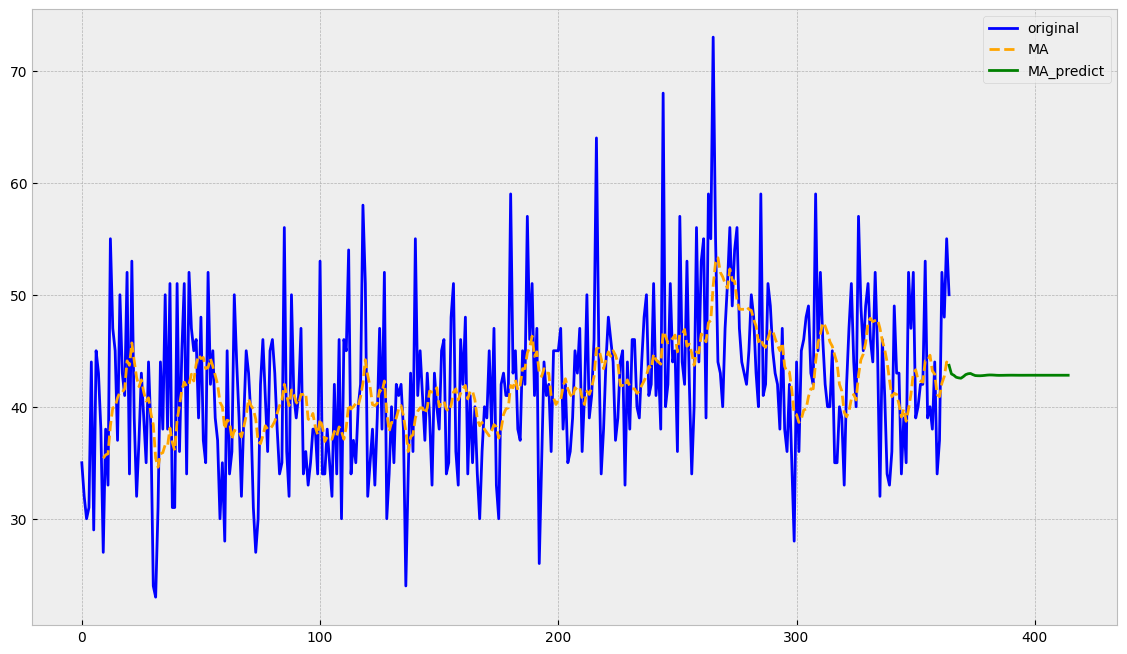

In [74]:
# графики MA и WMA

lag = 10 # окно 20 дней
w =  [1, 2, 3, 5, 8, 13, 21, 34, 55, 89]

wma_plt(stac, w, predict_n)

ma_plt(stac, lag, predict_n)

Для повышения качества прогноза стационарного ряда, необходимо увеличивать размер окна (MA) и большее количество весов (WMA)

1


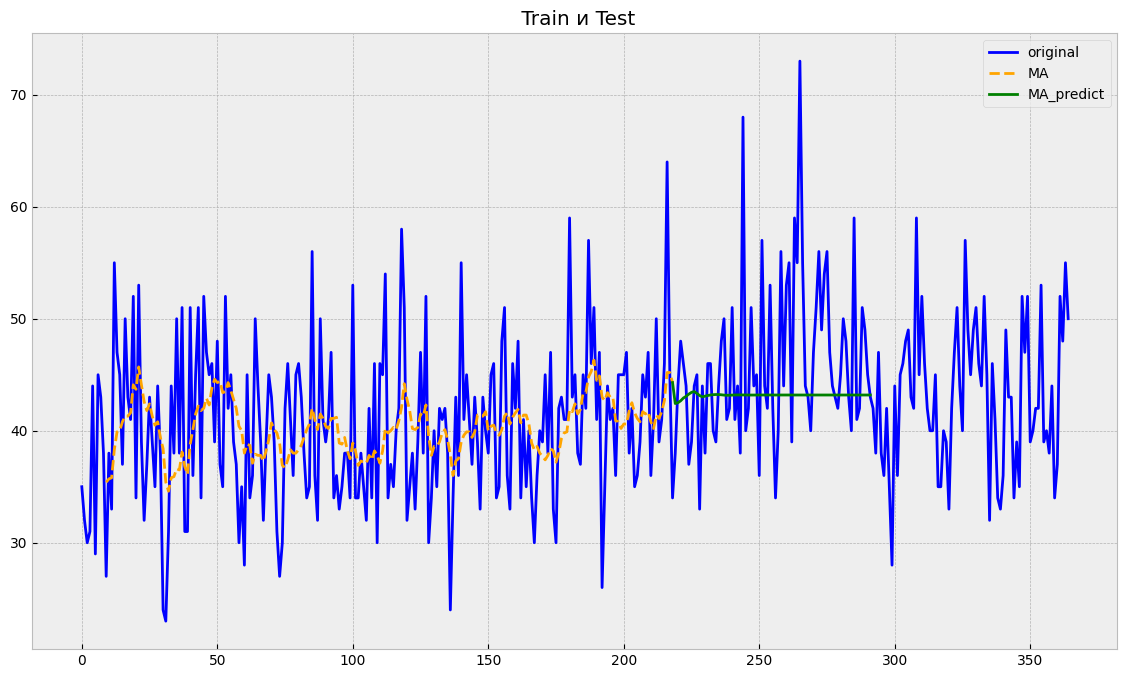

1
MA MSE =  60.94504528180944


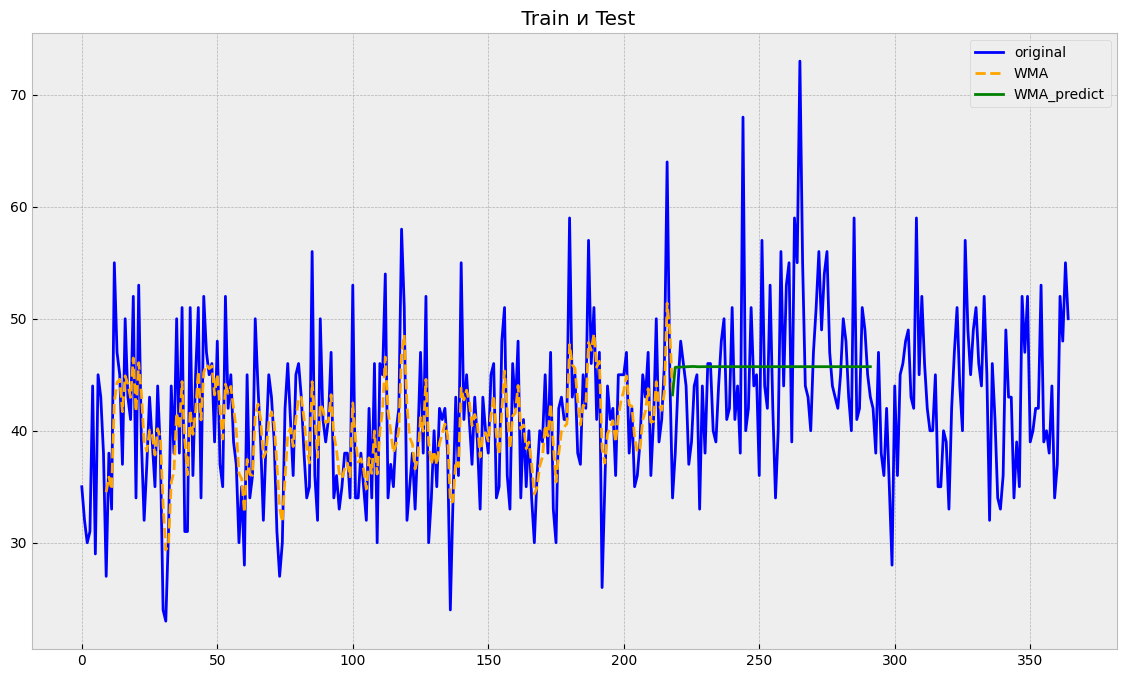

WMA MSE =  52.33090504939263


In [75]:
#  построим график на выборке train, test и определим ошибку

ma_plt (train, lag, predict_n = len(test), ser_plt = stac, title_plt = "Train и Test")
print('MA MSE = ', ma_mse(train, test, lag))

wma_plt (train, w, predict_n = len(test), ser_plt = stac, title_plt = "Train и Test")
print('WMA MSE = ', wma_mse(train, test, w))

Значение ошибки за пределами окна сходится к среднему значению

#2. Нестационарный ряд.
Датасет "Monthly sales of company X"

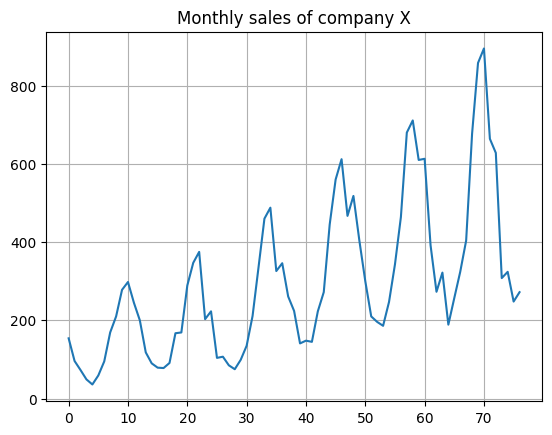

In [76]:
# Визуализация графика

name ='Monthly sales of company X'

no_stac = sales_of_company_x['Count']

plt.plot(no_stac)
plt.title(name)
plt.grid()
plt.show()

Ряд нестационарный - присутствует сезонности и тренд. Учитывая эти факторы выберем модель TEMA

In [84]:
#  тренд
def initial_trend(ser, season_len):
  _sum =0.0
  for i in range(season_len):
    _sum += float(ser[i + season_len] - ser[i]) / season_len
  return _sum / season_len

# сезонность
def initial_seasonal_components(ser, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(ser) / slen)

    # вычисляем средние за сезон
    for j in range(n_seasons):
        _sum = sum(ser[slen * j : slen * j + slen]) # суммируем все значения внутри сезона
        season_averages.append(_sum / float(slen))

    for i in range(slen):
        sum_of_vals_over_avg = 0.0

        for j in range(n_seasons):
            # суммируем отклонения от средних по каждой i-ой компоненте каждого блока (сезона)
            sum_of_vals_over_avg += ser[slen * j + i] - season_averages[j]
        # усредняем
        seasonals[i] = sum_of_vals_over_avg / float(n_seasons)
    # получаем список средних значений каждой i-ой компоненты сезона (между сезонами)
    return seasonals

#  Метод TEMA
def tema(ser, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(ser, slen)

    for i in range(len(ser)+n_preds):
        if i == 0: # initial values
            smooth = ser[0]
            trend = initial_trend(ser, slen)
            result.append(ser[0])
            continue
        if i >= len(ser): # we are forecasting
            m = i - len(ser) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = ser[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result


#  визуализация графика (TEMA и предсказания)
def tema_plt (ser, slen, alpha, beta, gamma, n_preds, ser_plt=None, title_plt=None):
    if ser_plt is None:
        ser_plt = ser
    title = f"alpha={alpha}, beta={beta}, gamma={gamma}"
    if title_plt is not None:
        title += " " + title_plt

    t = tema(ser, slen, alpha, beta, gamma, n_preds)

    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_plt, color='blue',label='original')
        plt.plot(t[:len(ser)], label='TEMA', color='orange', linestyle='dashed')
        plt.plot([x + len(ser) for x in range(-1, n_preds)], t[len(ser) - 1:], color='green', linewidth='4', label='TEMA predict')
        plt.title(title)
        plt.legend()
        plt.show()


# TEMA - определение ошибки ф-ции
def tema_mse ( opt_x, *param):
    train = param[0]
    test = param[1]
    slen = param[2]
    alpha, beta, gamma = opt_x
    res = tema(train, slen, alpha, beta, gamma, len(test))
    predictions = res[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [78]:
#  определим сезонность

slen = fun_series (no_stac, indx=12)['Lag'][0]

print('сезонность: ', slen)

fun_series (no_stac, indx=12).style.background_gradient(cmap='YlOrRd',axis=0)

сезонность:  12


,Lag,R
0,12,0.958803
1,11,0.877037
2,1,0.874519
3,2,0.670692
4,10,0.661978
5,3,0.386418
6,9,0.384095
7,4,0.121544
8,8,0.096070
9,5,-0.069430


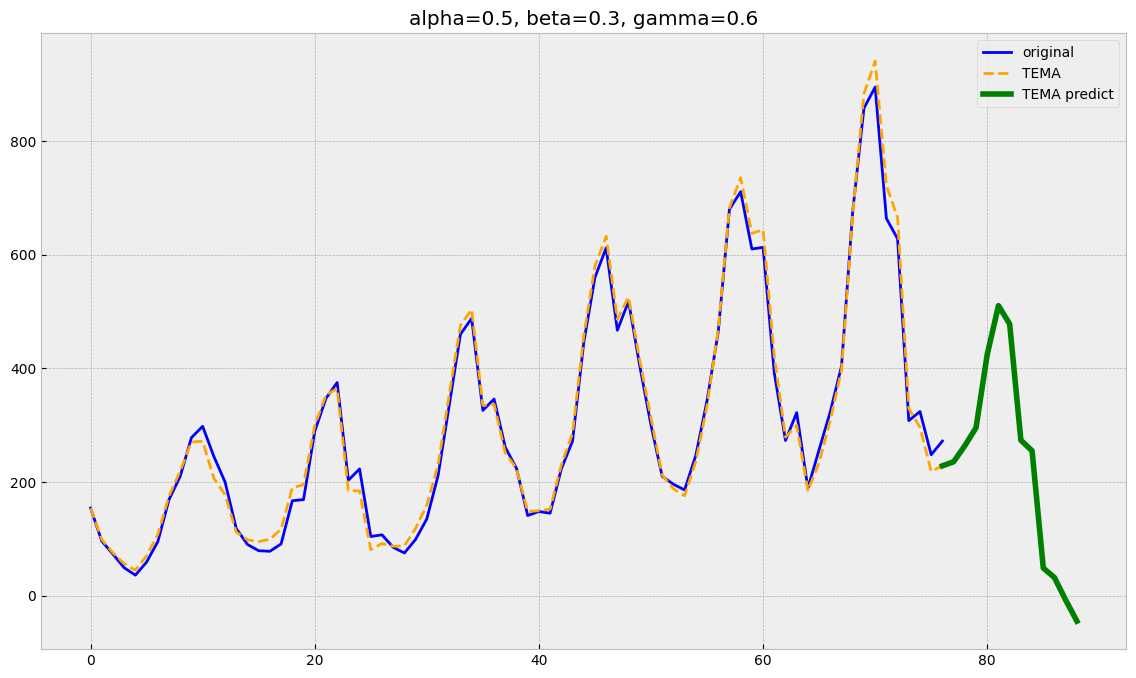

In [99]:
#  пострим прогноз с произвольными параметрами alpha, beta, gamma

n_pred = 12 # прогноз на 12 месяцев

tema_plt( no_stac, slen, 0.5, 0.3, 0.6, n_pred )

In [96]:
# Разобьем выборку на train, test и val. Подберем параметры alpha, beta и gamma.

train, test, val = split_train_test_val(no_stac, 0.8, 0.1)

opt = minimize(tema_mse, [0, 0, 0], args=(train, test, slen), bounds=((0, 1), (0, 1), (0, 1)))
alpha_opt, beta_opt, gamma_opt = opt.x
print(f"alpha: {alpha_opt}, beta: {beta_opt}, gamma: {gamma_opt}.")

alpha: 0.1935367382771965, beta: 0.3704407045840559, gamma: 0.7285867779336532.


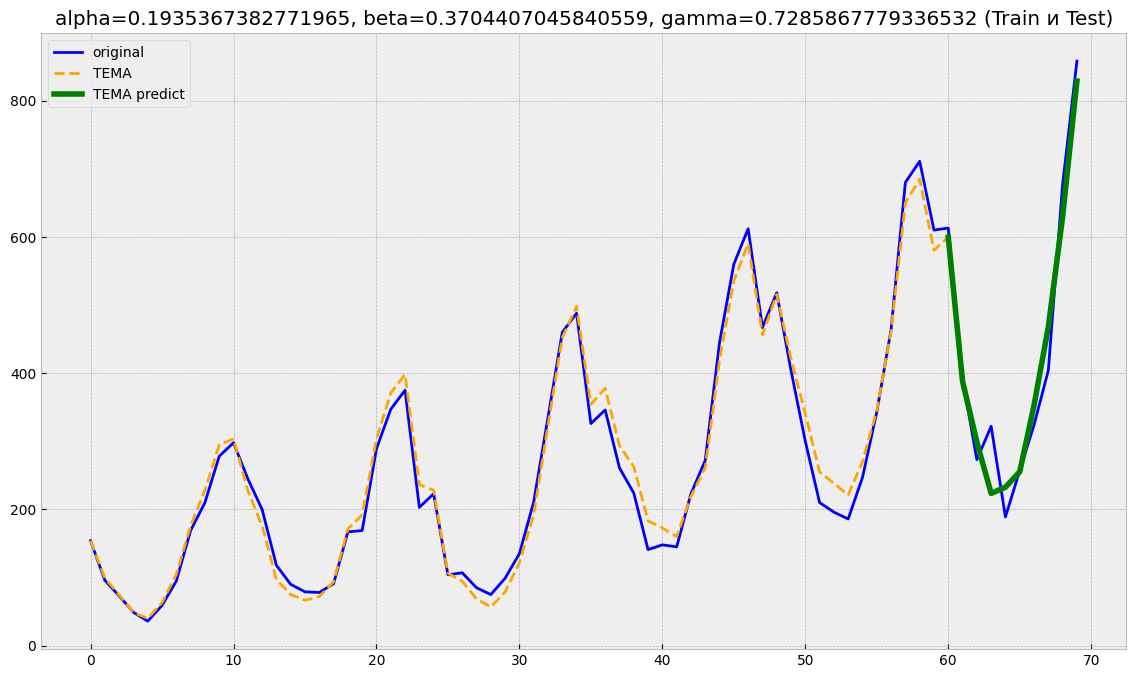

MSE: 2246.9150841048095.


In [97]:
# построим график для новых значений alpha, beta и gamma, и определим ошибку

tema_plt(train, slen, alpha_opt, beta_opt, gamma_opt, n_preds=len(test), ser_plt=train._append(test), title_plt="(Train и Test)")
print(f"MSE: {tema_mse(opt.x, train, test, slen)}.")

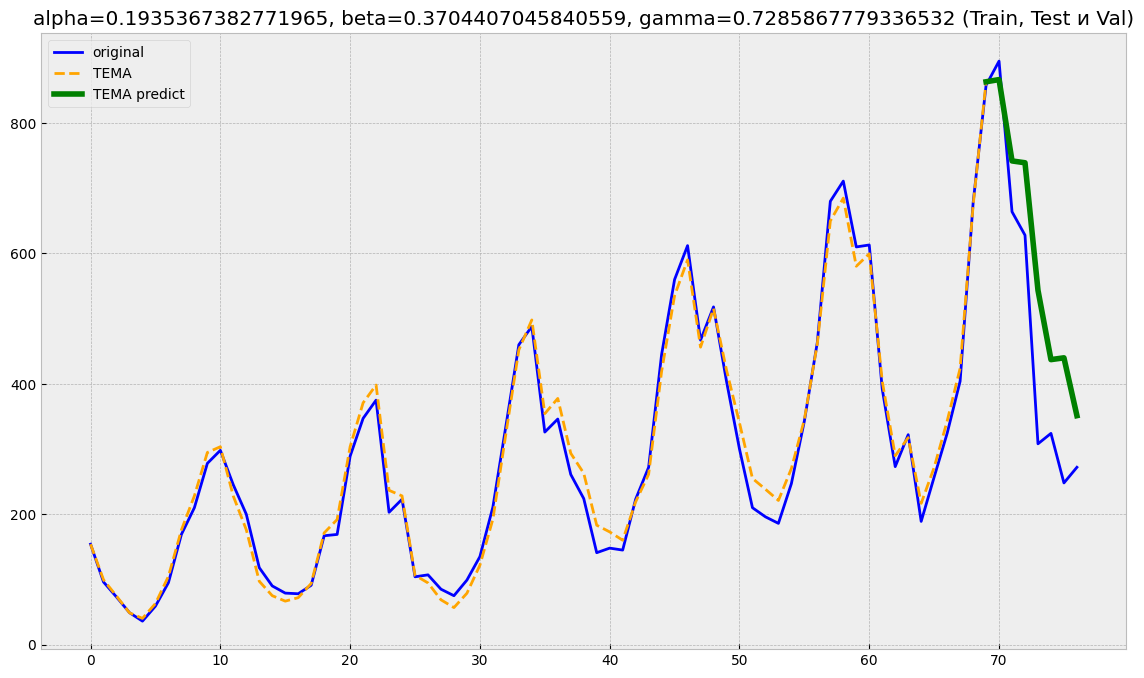

MSE: 18654.228514036706.


In [98]:
#  построим график на Val выборке и определим ошибку

tema_plt(train._append(test), slen, alpha_opt, beta_opt, gamma_opt, n_preds=len(val), ser_plt=no_stac, title_plt="(Train, Test и Val)")
print(f"MSE: {tema_mse(opt.x, train._append(test), val, slen)}.")


Модель TEMA хорошо справилась с усреднением. Ошибка MSE для подобранных параметров на выборке VAL стала ниже.

In [ ]:
Как видим, тройное усреднение справилось довольно неплохо, хотя и MSE подросла в сравнении с той, относительно которой производился подбор параметров.